In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipypb import irange

from DataProcessor import DataProcessor
from evaluation import evaluate, evaluation_callback

from mf import (
    mf,
    get_scores_generator,
    get_conf_mtx_lap_smooth,
    dense_Cui,
    main_objective,
)

from random_grid import random_grid
from experiment import (
    find_optimal_params,
    print_metrics,
    print_norms,
    print_objective_scores,
)

# Load and prepare the data:

In [2]:
data_file_name = "./data/lsapp.csv"
process_data = DataProcessor(
    data_file_name,
    column_names='userid,appid,timestamp',
    session_break_delta='15min',
)

process_data.prepare_data(
    usecols=['userid', 'appid', 'timestamp'],
    test_interval='14d',
    valid_interval='7d',
    min_sess_length=2,
    window="3s"
)

# define valuable params of the data:
n_users, n_items = process_data.n_users, process_data.n_items
user_col, item_col = process_data.userid, process_data.itemid

# MF:

$\mathcal{L} = \sum_{u = 1}^M\left(\mathbf{r}_u -\mathbf{a}_u\right)^\top\mathbf{C}_u\left(\mathbf{r}_u - \mathbf{a}_u\right) + $
$\dfrac{\lambda}{2}\left(\left\|\mathbf{P}\right\|^2_F + \left\|\mathbf{Q}\right\|^2_F \right)$

$\mathbf{r}_u = \mathbf{Q}\mathbf{p}_u$

# Find optimal parameters on validation set. Full grid.

In [3]:
optimizer_mode = "adam"
find_optimal = False
save_result = False
result_fn = f"metrics_results/lsapp_score_params/mf_scores_params_{optimizer_mode}.csv"

fixed_params = {
    "n_users": n_users,
    "n_items": n_items,
    "user_col": user_col,
    "item_col": item_col,
    "optimizer_mode": optimizer_mode,
    "n_epochs": 4,
    'n_steps': 4,
    "seed": 13,
    "evaluation_callback": None,
    "iterator": range,
}

variable_params = {
    "pow_bool": [None,],
    'lap_smooth': [0.001, 0.01, 0.1, 0.5, 1.0],
    'n_factors': [24, 32, 64, 80],
    'regularization': [1e-2, 1e-1, 1e0],
    'mode': ["mf",],
    'lr': [1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4],
    'gamma': [0.01, 0.1, 0.5, 1]
}

if find_optimal:
    grid, param_names = random_grid(variable_params, n=0)
    score2params = find_optimal_params(
        mf,
        process_data.train,
        process_data.valid_sessions,
        process_data.seen_interactions,
        list(grid),
        param_names,
        fixed_params,
        get_scores_generator,
        model_name='MF',
        target_metric='hr',
        metric_k=5,
        show_result=True,
        main_iterator=irange,
    )

    best_variable_params = score2params[max(score2params)]
    if save_result:
        df_params = pd.DataFrame(score2params).T  
        for key in fixed_params:
            df_params.loc[:, key] = fixed_params[key]
        df_params = df_params.rename_axis('score').reset_index(level=0)
        df_params.to_csv(result_fn, sep=',', header=True)
else: 
    if optimizer_mode == "adam":
        best_variable_params = {
            'pow_bool': None,
            'lap_smooth': 0.001,
            'n_factors': 80,
            'regularization': 0.01,
            'mode': 'mf',
            'lr': 1e-07,
            'gamma': 1,
        }
    elif optimizer_mode == "sgd":
        best_variable_params = {
            'pow_bool': None,
            'lap_smooth': 0.001,
            'n_factors': 80,
            'regularization': 0.01,
            'mode': 'mf',
            'lr': 1e-07,
            'gamma': 1,
        }
    else:
        assert False, "bad optimizer mode"

# Plot evaluation by epoch:

In [4]:
# Prepare for RMSE:
C, c = get_conf_mtx_lap_smooth(
    process_data.train,
    n_users,
    n_items,
    user_col,
    item_col,
    alpha=best_variable_params["lap_smooth"],
    gamma=best_variable_params["gamma"],
)


Cui = dense_Cui(C, c)

rmse_params={
    "C": Cui,
    "A": process_data.seen_interactions.A,
}

 [████████████████████████████████████████████████████████████] 20/20 [00:12<00:01, 0.62s/it]

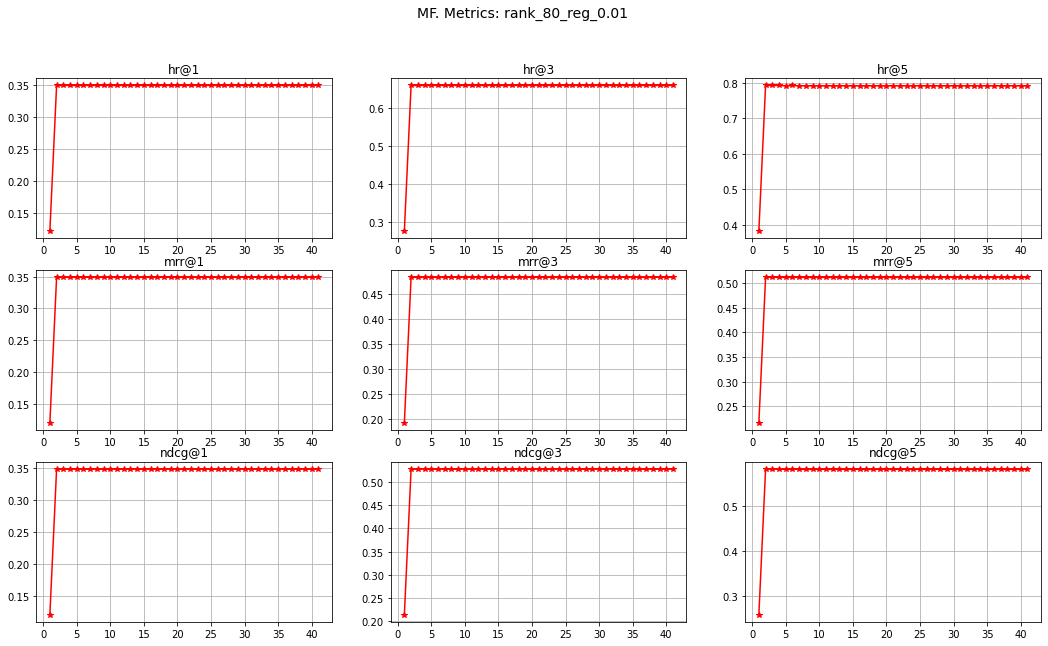

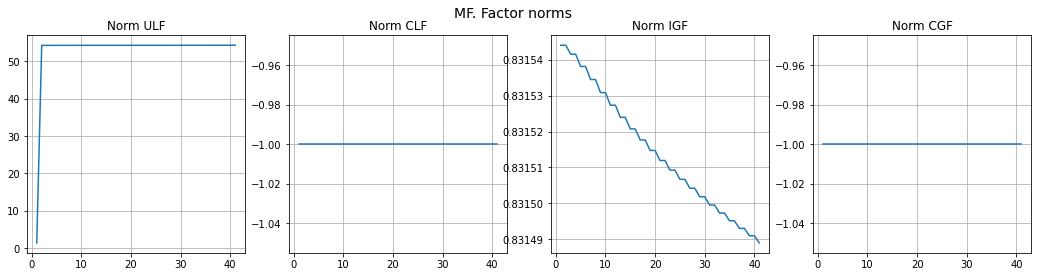

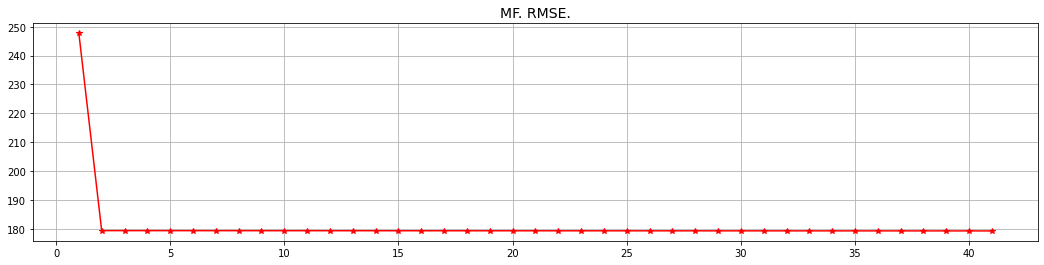

In [5]:
scorer_mode = best_variable_params["mode"]
best_variable_params_temp = {i:v for i,v in best_variable_params.items() if i != "mode"}

smf_callback = evaluation_callback(
    get_scores_generator,
    process_data.valid_sessions,
    process_data.seen_interactions, 
    factor_names=["ULF", "CLF", "IGF", "CGF"],
    scorer_mode=scorer_mode,
    rmse_loss=main_objective,
    rmse_params=rmse_params,
)

fixed_params_temp = fixed_params.copy()
fixed_params_temp["evaluation_callback"] = smf_callback
fixed_params_temp["iterator"] = irange
fixed_params_temp["n_epochs"] = 20

local_factors, global_factors = mf(
    process_data.train,
    **fixed_params_temp,
    **best_variable_params_temp,
)

# METRICS:
model_name = "MF"
x_axis = np.arange(1, fixed_params_temp["n_epochs"]*2 + 2)
print_metrics(
    x_axis,
    smf_callback.stat,
    model_name,
    best_variable_params_temp["n_factors"],
    best_variable_params_temp["regularization"],
)

# NORMS:
print_norms(x_axis, smf_callback.stat, model_name)

# RMSE:
print_objective_scores(x_axis, smf_callback.rmse, model_name)

# Retrain the model on train + validation set with optimal parameters:

In [6]:
train_valid = pd.concat([process_data.train, process_data.valid], ignore_index=True)

local_factors, global_factors = mf(
    train_valid,
    **fixed_params,
    **best_variable_params_temp
)

up_generate_scores = get_scores_generator(local_factors, global_factors, mode=scorer_mode)
seen_interactions = process_data.get_seen_interactions(train_valid)

metrics_df, user_stats = evaluate(
    up_generate_scores,
    process_data.test_sessions,
    seen_interactions,
)

test_results = (
    metrics_df
    .reset_index()
    .groupby(["topk"])
    .mean()[["hr", "mrr", "ndcg"]]
)

test_results

metrics,hr,mrr,ndcg
topk,,,
1,0.380471,0.380471,0.380471
3,0.628876,0.487525,0.523726
5,0.780103,0.522989,0.586802


# Dataframe with results:

In [7]:
ks = [1, 3, 5]
col_names = [f'HR@{i}' for i in ks] + [f'MRR@{i}' for i in ks] + [f'NDCG@{i}' for i in ks]
res_df = pd.DataFrame(columns=col_names) 

In [8]:
res = test_results
res_df.loc["MF", :] = res.values.reshape(1, 9, order='F').squeeze()
res

metrics,hr,mrr,ndcg
topk,,,
1,0.380471,0.380471,0.380471
3,0.628876,0.487525,0.523726
5,0.780103,0.522989,0.586802


# Show resulting table:

In [9]:
res_df = res_df.rename_axis('Models').reset_index(level=0)
res_df.loc[:, col_names] = res_df[col_names].applymap(lambda x: f"{x:.3f}")
res_df.to_csv("metrics_results/lsapp/mf.csv", sep=',', header=True)
print(res_df.to_latex(index=False))

\begin{tabular}{llllllllll}
\toprule
Models &  HR@1 &  HR@3 &  HR@5 & MRR@1 & MRR@3 & MRR@5 & NDCG@1 & NDCG@3 & NDCG@5 \\
\midrule
    MF & 0.380 & 0.629 & 0.780 & 0.380 & 0.488 & 0.523 &  0.380 &  0.524 &  0.587 \\
\bottomrule
\end{tabular}

